In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import stats
import os
from matplotlib import rc
import pandas as pd
#import statsmodels.api as sm
import importlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
#sns.set('talk')
import corner


import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

#rc('font',**{'family':'serif'})
#rc('text', usetex=True)

np.random.seed(4)

In [75]:
SMALL_SIZE = 30
MEDIUM_SIZE = 32
BIGGER_SIZE = 26


plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=26)    # fontsize of the tick labels
plt.rc('ytick', labelsize=26)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#rc('font',**{'family':'serif'})
#rc('text', usetex=True)

In [76]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies0 = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc0 = Masses['E_unc'].to_numpy()


In [152]:
# select spaced energies over interval

start = 30
step = 3
stop = 240

Energies = Energies0[start:stop:step]
Energies_unc = Energies_unc0[start:stop:step]
A = A0[start:stop:step]
Z = Z0[start:stop:step]
N = N0[start:stop:step]

print(len(A))

70


In [153]:
evenodd = 0
eveneven = 0
oddodd = 0

for i in range(len(A)):
    Atot = Z[i]+N[i]
    if Atot % 2 == 0:
        if Z[i] % 2 == 0:
            eveneven += 1
        else:
            oddodd += 1
    else:
        evenodd += 1
        
print(eveneven)
print(evenodd)
print(oddodd)

35
35
0


In [78]:
ndim = 6

In [79]:
# define parameter space


theta_0_bound = np.array([5.9, 6.7]).reshape(1,-1)
theta_1_bound = np.array([-0.14, -0.10]).reshape(1,-1)
theta_2_bound = np.array([0.47, 0.67]).reshape(1,-1)
theta_3_bound = np.array([0.0035, 0.0055]).reshape(1,-1) # keep
theta_4_bound = np.array([0.12, 0.19]).reshape(1,-1)
theta_5_bound = np.array([0, 0.2]).reshape(1,-1)


parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)
theta_5_vals = np.linspace(parameter_bounds[5,0], parameter_bounds[5,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)


In [80]:
def LiquidDropModel(A, Z, N, *parameters):
    
    indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(2*A**(-0.5))]
    
    E_B = 0
    
    for i in range(len(parameters)):
        E_B += parameters[i]*indep_var[i]
    
    return E_B


def LiquidDropModelTrue(a0, a1, a2, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0))


In [81]:
indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(0.5*A**(-0.5))]

def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X

X3d = np.zeros((len(A),3))
for i in range(3):
    X3d[:,0] = np.ones_like(A)
    X3d[:,1] = A
    X3d[:,2] = A**(2.0/3.0)
    

X2 = np.zeros((len(A),ndim))
for i in range(ndim):
    X2[:,1] = A
    X2[:,2] = A**(2.0/3.0)
    X2[:,3] = Z*(Z-1) * A**(-1.0/3.0)

In [82]:
clf_3d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(3), Energies)

clf_4d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(4), Energies)

clf_5d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(5), Energies)

clf_6d = skl.LinearRegression(fit_intercept=False).fit(design_matrix(6), Energies)

clf_3d2 = skl.LinearRegression(fit_intercept=False).fit(X2, Energies)

print('3D coefficients : ' + str(clf_3d.coef_))
print('4D coefficients : ' + str(clf_4d.coef_))
print('5D coefficients : ' + str(clf_5d.coef_))
print('6D coefficients : ' + str(clf_6d.coef_))
preds_6d = clf_6d.predict(design_matrix(6))
preds_5d = clf_5d.predict(design_matrix(5))
preds_4d = clf_4d.predict(design_matrix(4))
preds_3d = clf_3d.predict(X3d)

preds_3d2 = clf_3d2.predict(X2)

err3d = np.sum(np.square(Energies-preds_3d))
err4d = np.sum(np.square(Energies-preds_4d))
err5d = np.sum(np.square(Energies-preds_5d))
err6d = np.sum(np.square(Energies-preds_6d))

pred_sigmas = [np.sqrt(err3d / (len(Energies) - 3)), np.sqrt(err4d / (len(Energies) - 4)), \
                np.sqrt(err5d / (len(Energies) - 5)), np.sqrt(err6d / (len(Energies) - 6))]
#pred_sigma = np.sqrt(np.var(err))
pred_sigma_6d = np.sqrt(err6d / (len(Energies) - 6))
pred_sigma_5d = np.sqrt(err5d / (len(Energies) - 5))
pred_sigma_4d = np.sqrt(err4d / (len(Energies) - 4))
pred_sigma_3d = np.sqrt(err3d / (len(Energies) - 3))

print('3D sigma_model : ' + str(pred_sigma_3d) )
print('4D sigma_model : ' + str(pred_sigma_4d) )
print('5D sigma_model : ' + str(pred_sigma_5d) )
print('6D sigma_model : ' + str(pred_sigma_6d) )

print((Energies[0]*1.008)-Energies[0])



er = np.sqrt((10*((Energies[0]*1.002)-Energies[0])**2/9))
print(er)

errs = np.zeros((len(A)))
for i in range(len(A)):
    if A[i] < 40:
        errs[i] = 0.997
        
    elif A[i] < 140:
        errs[i] = 0.136
    elif A[i] < 200:
        errs[i] = 0.072
    else:
        errs[i] = 0.018
#errs = [0.997, 0.136, 0.072, 0.018]
# < 40: 11 % : 0.997
# < 140: 1.5% : 0.136 
# < 200: 0.8% : 0.072
# > 200: 0.2% : 0.018

3D coefficients : [ 7.02560505 -0.03948287  0.25748689]
4D coefficients : [ 6.71965468e+00 -6.15322219e-02  3.48443601e-01  1.47821478e-03]
5D coefficients : [ 5.04377062 -0.18510828  0.8714014   0.00710222  0.29118961]
6D coefficients : [ 4.9989218  -0.18596768  0.87626752  0.00713257  0.29235873  0.23513447]
3D sigma_model : 0.12608898730023638
4D sigma_model : 0.11538310272115532
5D sigma_model : 0.05756214582779564
6D sigma_model : 0.05609221971059528
0.055421855999999714
0.014604941426155428


Text(0.5, 0, 'Atomic Mass Number, A')

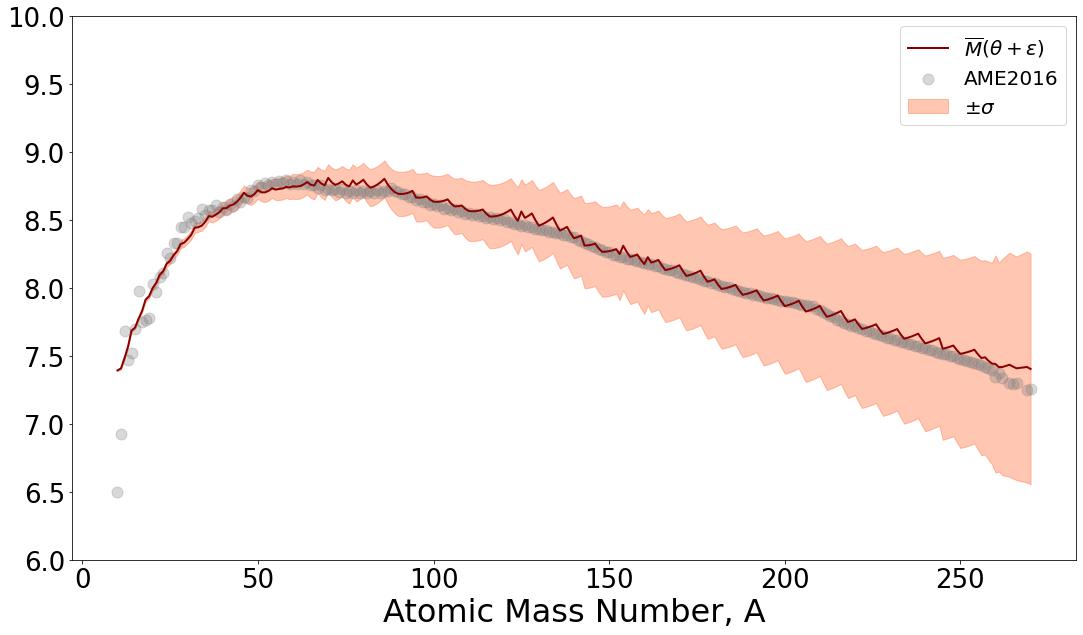

In [190]:
# look at small pertubations on parameters

fig, ax = plt.subplots(figsize=(18,10))
# plot datapoints
ax.scatter(A0, Energies0, color='gray', s=120, zorder=2, alpha=0.3, label='AME2016')
# plot with true coefs (5d model)
#ax.plot(A0, LiquidDropModel(A0, Z0, N0, *clf_5d.coef_), zorder=3, linewidth=3, color='black', label=r'$M(\theta)$')

# add small pertubations to coef

pertubations = np.linspace(0.0001, 0.001, 10)
nperts = 100
EB_pert = np.zeros((nperts, len(A0)))

for i in range(nperts):
    epsilon = np.random.normal(0,0.0005,len(clf_5d.coef_))
    #epsilon = np.random.uniform(0,s,len(clf_6d.coef_))
    coef_peturbed = clf_5d.coef_ + epsilon
    
    EB_pert[i] = LiquidDropModel(A0, Z0, N0, *coef_peturbed)

    # plot with peturbed coefs (5d model)
    #if i == 0:
        #ax.plot(A0, LiquidDropModel(A0, Z0, N0, *coef_peturbed),\
            #color='orangered', alpha=0.6, zorder=1, label=r'$M(\theta+\epsilon)$')
    #else:
        #ax.plot(A0, LiquidDropModel(A0, Z0, N0, *coef_peturbed),\
            #color='orangered', alpha=0.2, zorder=1)

eb_mean = np.mean(EB_pert, axis=0)
eb_var = np.var(EB_pert, axis=0)

ax.plot(A0, eb_mean,\
            color='darkred', linewidth=2, alpha=1, zorder=3, label=r'$\overline{M}(\theta+\epsilon)$')

ax.fill_between(A0, eb_mean+np.sqrt(eb_var), eb_mean-np.sqrt(eb_var),\
            color='orangered', alpha=0.3, zorder=1, label=r'$\pm \sigma$')


ax.legend(loc='best')
ax.set_ylim([6,10])
ax.set_xlabel('Atomic Mass Number, A')
#ax.set_ylabel(r'$E_{\textrm{B}}$/Nucleon (MeV)')



ValueError: The lengths of the data (30) and the error 216 do not match

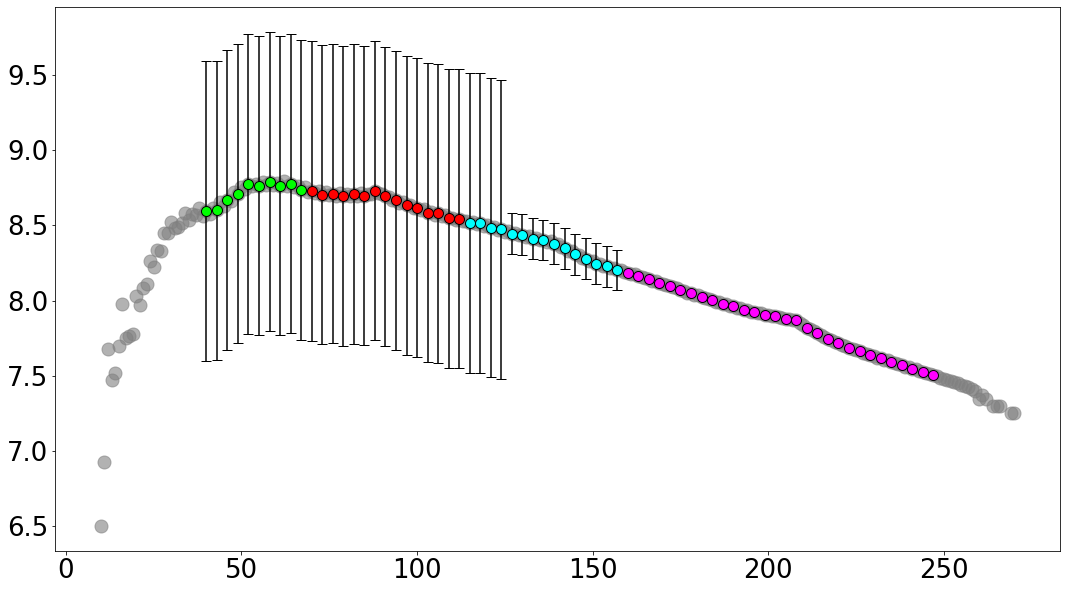

In [166]:
fig, ax = plt.subplots(figsize=(18,10))

ax.scatter(A0, Energies0, color='gray', s=170, zorder=1, alpha=0.6, label='AME2016')

ax.errorbar(A[0:10], Energies[0:10], yerr = errs[0:10], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='lime', mec='black', ms=10, zorder=2, \
            label='Wave 1 Observables')

ax.errorbar(A[10:25], Energies[10:25], yerr = errs[10:25], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='red', mec='black', ms=10, zorder=2, \
            label='Wave 2 Observables')

ax.errorbar(A[25:40], Energies[25:40], yerr = errs[25:40], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='cyan', mec='black', ms=10, zorder=2, \
            label='Wave 3 Observables')

ax.errorbar(A[40:], Energies[40:], yerr = errs[40:], marker='o', ecolor='black', \
            capsize=5, ls='none', mfc='magenta', mec='black', ms=10, zorder=2, \
            label='Wave 3 Observables')


ax.set_xlabel('Atomic Mass Number, A')
#ax.set_ylabel(r'$E_{\textrm{B}}$/Nucleon (MeV)')

ax.legend(loc='best')
#plt.savefig('figures/observables.png', bbox_inches='tight', facecolor='white', transparent=False)

Text(0.5, 1.0, '24 Output Predictions, 6D Model (aV,aS,aC)')

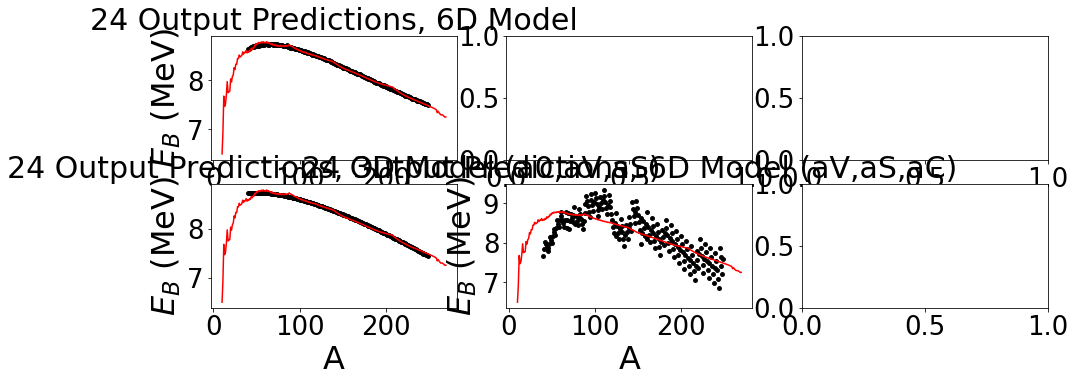

In [12]:
# check for most important active variables


fig, axes = plt.subplots(2,3,figsize=(15,5))
axes[0,0].scatter(A, preds_6d, color='black', s=15)
axes[0,0].plot(A0, Energies0, color='red')
axes[0,0].set_xlabel('A')
axes[0,0].set_ylabel(r'$E_{B}$ (MeV)')
axes[0,0].set_title('24 Output Predictions, 6D Model')

axes[1,0].scatter(A, preds_3d, color='black', s=15)
axes[1,0].plot(A0, Energies0, color='red')
axes[1,0].set_xlabel('A')
axes[1,0].set_ylabel(r'$E_{B}$ (MeV)')
axes[1,0].set_title('24 Output Predictions, 3D Model (a0,aV,aS)')

axes[1,1].scatter(A, preds_3d2, color='black', s=15)
axes[1,1].plot(A0, Energies0, color='red')
axes[1,1].set_xlabel('A')
axes[1,1].set_ylabel(r'$E_{B}$ (MeV)')
axes[1,1].set_title('24 Output Predictions, 6D Model (aV,aS,aC)')


In [13]:
variances = []
for i in range(4):
    variances.append(np.mean(Energies_unc)**2 + pred_sigmas[i]**2)

print(variances)

[0.0012098621568389014, 0.001166696088843878, 0.0004874536115329713, 0.00046844621867658657]


In [14]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [15]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [16]:
A_matrices = []
b = []

for i in range(4):
    A_matrices.append(A_matrix(design_matrix(i+3), variances[i]))
    b.append(Energies / np.sqrt(variances[i]))


#A3d = A_matrix(X3d, variance)
#b = Energies / np.sqrt(variance)


In [17]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [18]:
thetas = []
for i in range(4):
    thetas.append(solve_theta(A_matrices[i], b[i]))

In [19]:
H_matrices = []
covariance_matrices = []

for i in range(4):
    H_matrices.append(H_matrix(A_matrices[i]))

for i in range(4):
    covariance_matrices.append(covariance(design_matrix(i+3), variances[i]))

In [20]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * np.sqrt(5.991) * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color,linewidth=3)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [21]:
dec_list = [1,2,2,3,3,2]

In [22]:
def plot_ellipses(fig, parameter_bounds, H, theta_best, theta_vals, color):
    theta_names = [r'$a_{0}$', r'$a_{\textrm{v}}$', r'$a_{\textrm{s}}$', r'$a_{\textrm{c}}$', r'$a_{\textrm{a}}$', r'$a_{\textrm{p}}$']
    for i in range(ndim):
        for j in range(ndim):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                #ax.axis('off')
                ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color='black', linewidth=3)
                ax.axvline(theta_best[i], color='black', linestyle='--',linewidth=3)
                #ax.axvline(theta_best[i]+2*np.sqrt(H[i,i]), linestyle='--', color='black')
                #ax.axvline(theta_best[i]-2*np.sqrt(H[i,i]), linestyle='--', color='black')
                ax.set_xticks(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5))
                ax.set_xticklabels(np.around(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5),dec_list[i]), rotation = 45, ha="right")
                
                if i == 3:
                    ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                   str(round(np.sqrt(H[i,i]),4)))
                else:
                    ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 3)) + r'$\pm$' + \
                                       str(round(np.sqrt(H[i,i]),3)))
                
            elif i < j:
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                #ax.axvline(theta_best[i]+2*np.sqrt(H[i,i]), linestyle='--', color='black')
                #ax.axvline(theta_best[i]-2*np.sqrt(H[i,i]), linestyle='--', color='black')
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                if j == ndim-1:
                    ax.set_ylabel(theta_names[j])
                    ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
                ax.set_xticks(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5))
                ax.set_xticklabels(np.around(np.linspace(parameter_bounds[i,0]*1.01, parameter_bounds[i,1], 5),dec_list[i]), rotation = 45, ha="right")
                ax.set_yticks(np.linspace(parameter_bounds[j,0]*1.01, parameter_bounds[j,1], 5))
                ax.set_yticklabels(np.around(np.linspace(parameter_bounds[j,0], parameter_bounds[j,1], 5),dec_list[j]), rotation = 45, ha="right")
                
            else:
                ax.axis('off')
                
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
                
        plt.tight_layout(pad=0.0)


In [23]:
color_list = ['black', 'plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(32,32))

plot_ellipses(fig, parameter_bounds, H_matrices[3], thetas[3], theta_vals, color_list[0])
#fig.suptitle(r'Analytical Likelihood (95% Isoprobability Surface)')
#plt.savefig('figures/6D_analytical_95iso.png', bbox_inches='tight', facecolor='white', transparent=False)

ValueError: 
a_{\textrm{p}}
   ^
Unknown symbol: \textrm, found '\'  (at char 3), (line:1, col:4)

ValueError: 
a_{\textrm{p}}
   ^
Unknown symbol: \textrm, found '\'  (at char 3), (line:1, col:4)

<Figure size 2304x2304 with 36 Axes>

In [ ]:
data =  np.random.multivariate_normal(thetas[3], H_matrices[3], size=2000)
figure = corner.corner(data,
                       quantiles=(0.16, 0.84),
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
#file2 = open("data/3D_analytic_mean.txt", "w")

#np.savetxt(file2, theta)
    
#file2.close()

#file1 = open("data/3D_analytic_cov.txt", "w")

#for i in range(H3d.shape[0]):
    #np.savetxt(file1, H3d[i])
    
#file1.close()


file2 = open("data/6D_analytic_mean.txt", "w")

np.savetxt(file2, thetas[3])
    
file2.close()

file1 = open("data/6D_analytic_cov.txt", "w")

for i in range(H_matrices[3].shape[0]):
    #np.savetxt(file1, H_matrices[2][i])
    np.savetxt(file1, covariance_matrices[3][i])
    
file1.close()
